In [19]:
import pandas as pd
import os
from datetime import datetime, timedelta
import lifetimes
from lifetimes.plotting import plot_probability_alive_matrix
import matplotlib.pyplot as plt

In [2]:
dir_path = 'D:/Training_BSE/marketing_analytics'
file_name = 'OnlineRetail.csv'

In [3]:
df_data = pd.read_csv(os.path.join(dir_path,file_name),encoding='iso-8859-1')

In [4]:
df_data['InvoiceDate'] = pd.to_datetime(df_data['InvoiceDate'],errors='coerce')

In [5]:
tx_uk = df_data.loc[df_data['Country']=='United Kingdom']

In [6]:
tx_uk['CustomerID'] = tx_uk['CustomerID'].astype(str).str.split('.').str[0]

In [8]:
max_date = tx_uk['InvoiceDate'].max()
tx_3M = tx_uk.loc[(tx_uk['InvoiceDate']<=max_date)&(tx_uk['InvoiceDate'] > (max_date-timedelta(days=90)))]
tx_6M = tx_uk.loc[(tx_uk['InvoiceDate'] > (max_date-timedelta(days=270)))&(tx_uk['InvoiceDate'] <=(max_date-timedelta(days=90)))]

In [9]:
tx_6M['Revenue'] = tx_6M['UnitPrice'] * tx_6M['Quantity']

In [10]:
s = lifetimes.utils.summary_data_from_transaction_data(tx_6M, 'CustomerID', 'InvoiceDate','Revenue').reset_index()

<AxesSubplot:ylabel='Frequency'>

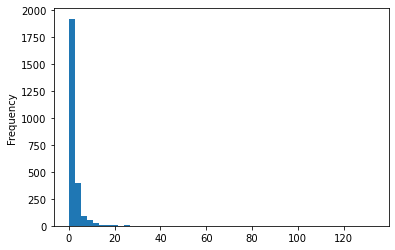

In [13]:
s['frequency'].plot(kind='hist',bins=50)

In [14]:
#One time Buyer
one_time_buyers = sum(s['frequency']==0)*100/s.shape[0]

In [15]:
one_time_buyers

40.90551181102362

In [16]:
#CLTV Formula
# CLTV = Expected Avg Purchase Value * Expected Average Transaction Count * Margin
# Alternate Formula of CLTV = (AverageValue * AverageTransaction) * Margin/ChurnRate <---ChurnRate = 1 - RepeatRate
#Fitting BetaGemetric / Negative Binomial Distribution
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.001)
model = bgf.fit(s['frequency'],s['recency'],s['T'])
model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.774372,0.036429,0.702971,0.845772
alpha,45.909361,2.655133,40.705301,51.113421
a,0.018712,0.013835,-0.008404,0.045828
b,0.234487,0.171773,-0.102189,0.571162


In [17]:
#Compute the Prpbability that a Customer is Active (i.e Recency is low)
s['Probability_Alive'] = bgf.conditional_probability_alive(s['frequency'],s['recency'],s['T'])

In [21]:
fig = plt.figure(figsize=(25,10))
plot_probability_alive_matrix

<function lifetimes.plotting.plot_probability_alive_matrix(model, max_frequency=None, max_recency=None, title='Probability Customer is Alive,\nby Frequency and Recency of a Customer', xlabel="Customer's Historical Frequency", ylabel="Customer's Recency", **kwargs)>

<Figure size 1800x720 with 0 Axes>

In [22]:
#Compute the probability that Customer will but in next time period.
t=30
s['pred_num_trxn'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,s['frequency'],s['recency'],s['T'])

In [23]:
s.head(10)

,CustomerID,frequency,recency,T,monetary_value,Probability_Alive,pred_num_trxn
0,12747,3.0,109.0,127.0,335.450000,0.987478,0.645229
1,12748,49.0,175.0,175.0,170.096735,0.999612,6.748396
2,12749,4.0,100.0,122.0,418.362500,0.988815,0.841706
3,12821,0.0,0.0,123.0,0.000000,1.000000,0.136121
4,12823,1.0,127.0,163.0,229.500000,0.899587,0.228588
5,12826,1.0,10.0,87.0,-6.600000,0.729433,0.290928
6,12828,2.0,31.0,39.0,94.255000,0.980444,0.956502
7,12830,4.0,80.0,80.0,1031.560000,0.994248,1.127919
8,12831,0.0,0.0,171.0,0.000000,1.000000,0.106220
9,12832,0.0,0.0,7.0,0.000000,1.000000,0.427482


In [24]:
ret_s = s.loc[(s['frequency']>0) & (s['monetary_value']>0)]

In [25]:
corr_matrix = ret_s[['frequency','monetary_value']].corr()

In [26]:
corr_matrix

,frequency,monetary_value
frequency,1.000000,0.264261
monetary_value,0.264261,1.000000


In [27]:
ret_s['monetary_value'] = ret_s['monetary_value'].abs()

In [28]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
model_money = ggf.fit(ret_s['frequency'],ret_s['monetary_value'])
summary = ggf.summary

In [29]:
summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.722641,0.274232,6.185146,7.260136
q,0.726589,0.025489,0.676630,0.776548
v,11.428290,0.415795,10.613332,12.243249


In [30]:
#Compute the Conditional Probability of Average Revenue
s['exp_avg_sales'] = ggf.conditional_expected_average_profit(s['frequency'],s['monetary_value'])

In [31]:
#CLV prediction
s['CLTV'] = ggf.customer_lifetime_value(bgf, s['frequency'], s['recency'], \
                                       s['T'], s['monetary_value'],\
                                        time = 1,freq = 'D',discount_rate=0.06)

In [36]:
s.head(10)

,CustomerID,frequency,recency,T,monetary_value,Probability_Alive,pred_num_trxn,exp_avg_sales,CLTV,Cluster
0,12747,3.0,109.0,127.0,335.450000,0.987478,0.645229,343.921884,209.347484,0
1,12748,49.0,175.0,175.0,170.096735,0.999612,6.748396,170.471457,1085.291415,0
2,12749,4.0,100.0,122.0,418.362500,0.988815,0.841706,425.546333,337.910421,0
3,12821,0.0,0.0,123.0,0.000000,1.000000,0.136121,-280.999311,-36.084724,0
4,12823,1.0,127.0,163.0,229.500000,0.899587,0.228588,251.142290,54.158577,0
5,12826,1.0,10.0,87.0,-6.600000,0.729433,0.290928,5.032983,1.381354,0
6,12828,2.0,31.0,39.0,94.255000,0.980444,0.956502,102.044223,92.080686,0
7,12830,4.0,80.0,80.0,1031.560000,0.994248,1.127919,1045.042588,1112.003016,0
8,12831,0.0,0.0,171.0,0.000000,1.000000,0.106220,-280.999311,-28.158243,0
9,12832,0.0,0.0,7.0,0.000000,1.000000,0.427482,-280.999311,-113.322753,0


In [33]:
from sklearn.cluster import KMeans
#Cluster the RFM part
kmeans = KMeans(n_clusters=3)
k_fit = kmeans.fit_predict(s[['CLTV']])
s['Cluster'] = k_fit

In [35]:
s.groupby(['Cluster'])['CLTV'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,2521.0,75.951618,196.991424,-206.442112,-38.096011,24.229419,124.604644,1673.846906
1,1.0,62241.019019,NaN,62241.019019,62241.019019,62241.019019,62241.019019,62241.019019
2,18.0,3814.410149,2539.776242,1951.033550,2275.382606,2938.072599,3790.582661,12241.738306


In [39]:
tx_3M_12749 = tx_3M.loc[tx_3M['CustomerID']=='12749']

In [44]:
tx_12749 = tx_3M_12749.groupby(['CustomerID']).agg(InvoiceCount = ('InvoiceNo','count'),UnitPrice = ('UnitPrice','mean'),Qty = ('Quantity','mean')).reset_index()

In [45]:
tx_12749

,CustomerID,InvoiceCount,UnitPrice,Qty
0,12749,71,5.449577,5.507042


In [47]:
(386.92*391/71)/3

710.2615962441314